In [2]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [5]:
RUN_ID = "run_2026_01_05_wide_mlp_v1"
model_save_name = "wide_mlp_v1"

In [6]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        return self.X[idx], self.y[idx]

In [7]:
BATCH_SIZE = 2048
num_workers = 0

TRAIN_PATH = Path("./dataset_bitmaps/bitboard_train.npz")
VAL_PATH = Path("./dataset_bitmaps/bitboard_val.npz")
TEST_PATH = Path("./dataset_bitmaps/bitboard_test.npz") 

train_dataloader = DataLoader(dataset=NPZChessDataset(TRAIN_PATH), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset(VAL_PATH), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset(TEST_PATH), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [8]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.03595895528793335


In [9]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([2048, 775]) dtype: torch.float32
y batch shape: torch.Size([2048]) dtype: torch.int64 classes in batch: [0, 1, 2, 3, 4, 5, 6]


In [10]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [11]:
class WideMLP(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.network(x)

In [12]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [13]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """

    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [14]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   epochs: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_loss = float("inf")
    best_model_weights = None
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch}: New Best Val Loss: {val_loss:.4f} (Saved)")
            torch.save(model.state_dict(), f"{model_save_name}.pth")
        else:
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Val Loss: {val_loss} | Val Acc: {val_acc}")

        # To plot results later
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Loss: {best_val_loss:.4f}")

    return results

In [15]:
from torchinfo import summary

model = WideMLP(input_shape=775,
                        hidden_units=2048,
                        output_shape=7).to(device)

summary(model, input_size=(2048, 775))

Layer (type:depth-idx)                   Output Shape              Param #
WideMLP                                  [2048, 7]                 --
├─Sequential: 1-1                        [2048, 7]                 --
│    └─Linear: 2-1                       [2048, 2048]              1,589,248
│    └─BatchNorm1d: 2-2                  [2048, 2048]              4,096
│    └─ReLU: 2-3                         [2048, 2048]              --
│    └─Dropout: 2-4                      [2048, 2048]              --
│    └─Linear: 2-5                       [2048, 2048]              4,196,352
│    └─BatchNorm1d: 2-6                  [2048, 2048]              4,096
│    └─ReLU: 2-7                         [2048, 2048]              --
│    └─Dropout: 2-8                      [2048, 2048]              --
│    └─Linear: 2-9                       [2048, 7]                 14,343
Total params: 5,808,135
Trainable params: 5,808,135
Non-trainable params: 0
Total mult-adds (G): 11.90
Input size (MB): 6.35
Forwar

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001)

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)


  1%|          | 1/100 [01:22<2:16:35, 82.78s/it]

Epoch 0: New Best Val Loss: 1.2867 (Saved)
Epoch: 0 | Train Loss: 1.381796304543813 | Train Acc: 0.4288085722514279 | Val Loss: 1.2866707816465723 | Val Acc: 0.4696299691089206


  2%|▏         | 2/100 [02:27<1:57:29, 71.93s/it]

Epoch 1: New Best Val Loss: 1.2222 (Saved)
Epoch: 1 | Train Loss: 1.264184116045634 | Train Acc: 0.4772880962811526 | Val Loss: 1.2221860716774195 | Val Acc: 0.4971527218456899


  3%|▎         | 3/100 [03:31<1:50:51, 68.57s/it]

Epoch 2: New Best Val Loss: 1.1869 (Saved)
Epoch: 2 | Train Loss: 1.2118267701466878 | Train Acc: 0.5004999979718328 | Val Loss: 1.1869087217203993 | Val Acc: 0.5146775010105835


  4%|▍         | 4/100 [04:41<1:50:46, 69.23s/it]

Epoch 3: New Best Val Loss: 1.1669 (Saved)
Epoch: 3 | Train Loss: 1.1758968878322178 | Train Acc: 0.5161706641841901 | Val Loss: 1.1669133061435035 | Val Acc: 0.5225421477012785


  5%|▌         | 5/100 [05:51<1:49:38, 69.25s/it]

Epoch 4: New Best Val Loss: 1.1541 (Saved)
Epoch: 4 | Train Loss: 1.1508264305326674 | Train Acc: 0.527291974948079 | Val Loss: 1.1541304262831755 | Val Acc: 0.5286556223815275


  6%|▌         | 6/100 [07:06<1:51:56, 71.46s/it]

Epoch 5: New Best Val Loss: 1.1414 (Saved)
Epoch: 5 | Train Loss: 1.1312693978945414 | Train Acc: 0.5359137805847612 | Val Loss: 1.141389717624456 | Val Acc: 0.5345264165385191


  7%|▋         | 7/100 [08:17<1:50:30, 71.30s/it]

Epoch 6: New Best Val Loss: 1.1301 (Saved)
Epoch: 6 | Train Loss: 1.1155317708651225 | Train Acc: 0.542970922978323 | Val Loss: 1.1300900171641197 | Val Acc: 0.5400102844333604


  8%|▊         | 8/100 [09:24<1:46:48, 69.66s/it]

Epoch 7: New Best Val Loss: 1.1256 (Saved)
Epoch: 7 | Train Loss: 1.1029063753551906 | Train Acc: 0.5484834558346313 | Val Loss: 1.1256095646998174 | Val Acc: 0.541647508340784


  9%|▉         | 9/100 [10:35<1:46:34, 70.27s/it]

Epoch 8: New Best Val Loss: 1.1186 (Saved)
Epoch: 8 | Train Loss: 1.0925401246282789 | Train Acc: 0.5530120132398754 | Val Loss: 1.1185753837787251 | Val Acc: 0.5452403968597673


 10%|█         | 10/100 [12:17<1:59:48, 79.88s/it]

Epoch 9: New Best Val Loss: 1.1111 (Saved)
Epoch: 9 | Train Loss: 1.0831083171102736 | Train Acc: 0.5574254011714693 | Val Loss: 1.1110620317605575 | Val Acc: 0.5488405236215049


 11%|█         | 11/100 [13:59<2:08:42, 86.77s/it]

Epoch 10: New Best Val Loss: 1.1097 (Saved)
Epoch: 10 | Train Loss: 1.074993934366438 | Train Acc: 0.561000945531542 | Val Loss: 1.109733738793448 | Val Acc: 0.5483718092740133


 12%|█▏        | 12/100 [15:21<2:05:02, 85.26s/it]

Epoch 11: New Best Val Loss: 1.1052 (Saved)
Epoch: 11 | Train Loss: 1.0675687171618145 | Train Acc: 0.5640601667964694 | Val Loss: 1.1051625690769418 | Val Acc: 0.5501664765050306


 13%|█▎        | 13/100 [16:43<2:02:21, 84.39s/it]

Epoch 12: New Best Val Loss: 1.1022 (Saved)
Epoch: 12 | Train Loss: 1.0604405213197072 | Train Acc: 0.5674041013596833 | Val Loss: 1.102245780388243 | Val Acc: 0.5522912498625392


 14%|█▍        | 14/100 [18:05<1:59:47, 83.57s/it]

Epoch 13: New Best Val Loss: 1.0983 (Saved)
Epoch: 13 | Train Loss: 1.0546986306508381 | Train Acc: 0.5698195032612928 | Val Loss: 1.098266982788112 | Val Acc: 0.5540035091471015


 15%|█▌        | 15/100 [19:26<1:57:24, 82.87s/it]

Epoch 14: New Best Val Loss: 1.0957 (Saved)
Epoch: 14 | Train Loss: 1.0492364641825358 | Train Acc: 0.572243100580867 | Val Loss: 1.095710371134631 | Val Acc: 0.5542504321509372


 16%|█▌        | 16/100 [20:47<1:55:17, 82.35s/it]

Epoch 15: New Best Val Loss: 1.0909 (Saved)
Epoch: 15 | Train Loss: 1.0443978617456224 | Train Acc: 0.5742724112474039 | Val Loss: 1.0908977767713242 | Val Acc: 0.5584067604297411


 17%|█▋        | 17/100 [22:11<1:54:27, 82.74s/it]

Epoch 16: New Best Val Loss: 1.0907 (Saved)
Epoch: 16 | Train Loss: 1.039338545507855 | Train Acc: 0.5767832737052181 | Val Loss: 1.0906703293120088 | Val Acc: 0.5576290754007229


 18%|█▊        | 18/100 [23:34<1:53:19, 82.92s/it]

Epoch 17: New Best Val Loss: 1.0881 (Saved)
Epoch: 17 | Train Loss: 1.0355991779433356 | Train Acc: 0.5779907065323209 | Val Loss: 1.0880675826463275 | Val Acc: 0.5578005824354946


 19%|█▉        | 19/100 [24:57<1:52:00, 82.96s/it]

Epoch 18: New Best Val Loss: 1.0877 (Saved)
Epoch: 18 | Train Loss: 1.0319950912528568 | Train Acc: 0.5799490654205608 | Val Loss: 1.0876523832005445 | Val Acc: 0.5581720065728673


 20%|██        | 20/100 [26:22<1:51:08, 83.36s/it]

Epoch 19: New Best Val Loss: 1.0843 (Saved)
Epoch: 19 | Train Loss: 1.0285793954531353 | Train Acc: 0.5813886118412512 | Val Loss: 1.0843324248294375 | Val Acc: 0.559345761864886


 21%|██        | 21/100 [27:43<1:49:10, 82.92s/it]

Epoch 20: Train Loss: 1.0245 | Val Loss: 1.0845
Epoch: 20 | Train Loss: 1.024465452035268 | Train Acc: 0.5830336006457685 | Val Loss: 1.084498826554204 | Val Acc: 0.5596233770888676


 22%|██▏       | 22/100 [29:05<1:47:17, 82.53s/it]

Epoch 21: New Best Val Loss: 1.0824 (Saved)
Epoch: 21 | Train Loss: 1.0216120136843787 | Train Acc: 0.5845987490264797 | Val Loss: 1.0823889915853637 | Val Acc: 0.5592153083855774


 23%|██▎       | 23/100 [30:26<1:45:26, 82.16s/it]

Epoch 22: New Best Val Loss: 1.0781 (Saved)
Epoch: 22 | Train Loss: 1.0182700500488282 | Train Acc: 0.5860740723163291 | Val Loss: 1.078128823444705 | Val Acc: 0.562041840082258


 24%|██▍       | 24/100 [31:47<1:43:39, 81.83s/it]

Epoch 23: Train Loss: 1.0156 | Val Loss: 1.0790
Epoch: 23 | Train Loss: 1.0156062968307071 | Train Acc: 0.5871087620878764 | Val Loss: 1.0790261351614683 | Val Acc: 0.5613766647426626


 25%|██▌       | 25/100 [33:09<1:42:08, 81.72s/it]

Epoch 24: New Best Val Loss: 1.0764 (Saved)
Epoch: 24 | Train Loss: 1.0125681330627865 | Train Acc: 0.5883277035468588 | Val Loss: 1.0764312912986547 | Val Acc: 0.5630304737827685


 26%|██▌       | 26/100 [34:30<1:40:40, 81.63s/it]

Epoch 25: New Best Val Loss: 1.0760 (Saved)
Epoch: 25 | Train Loss: 1.0098698203298782 | Train Acc: 0.5895719001492731 | Val Loss: 1.0759936835578685 | Val Acc: 0.5633929749984239


 27%|██▋       | 27/100 [35:52<1:39:15, 81.58s/it]

Epoch 26: New Best Val Loss: 1.0752 (Saved)
Epoch: 26 | Train Loss: 1.007401234600279 | Train Acc: 0.5908460584598909 | Val Loss: 1.0751557167072752 | Val Acc: 0.5634404300540996


 28%|██▊       | 28/100 [37:15<1:38:38, 82.20s/it]

Epoch 27: New Best Val Loss: 1.0706 (Saved)
Epoch: 27 | Train Loss: 1.0049615592426724 | Train Acc: 0.5917736366660176 | Val Loss: 1.0706125381863565 | Val Acc: 0.5657083801349462


 29%|██▉       | 29/100 [38:38<1:37:17, 82.21s/it]

Epoch 28: Train Loss: 1.0030 | Val Loss: 1.0707
Epoch: 28 | Train Loss: 1.0029623531500498 | Train Acc: 0.5928824539200416 | Val Loss: 1.070693823257811 | Val Acc: 0.5648142255814012


 30%|███       | 30/100 [40:00<1:36:05, 82.36s/it]

Epoch 29: Train Loss: 1.0011 | Val Loss: 1.0725
Epoch: 29 | Train Loss: 1.0011226858297984 | Train Acc: 0.5933532925266095 | Val Loss: 1.0724507067797533 | Val Acc: 0.5644408704997019


 31%|███       | 31/100 [41:20<1:33:42, 81.49s/it]

Epoch 30: New Best Val Loss: 1.0696 (Saved)
Epoch: 30 | Train Loss: 0.9991676263544295 | Train Acc: 0.5945146831191589 | Val Loss: 1.0695881758126788 | Val Acc: 0.565816517214934


 32%|███▏      | 32/100 [42:39<1:31:34, 80.81s/it]

Epoch 31: New Best Val Loss: 1.0672 (Saved)
Epoch: 31 | Train Loss: 0.9967518061267006 | Train Acc: 0.5953265369450934 | Val Loss: 1.0672146004621486 | Val Acc: 0.5665729002900199


 33%|███▎      | 33/100 [43:51<1:27:24, 78.28s/it]

Epoch 32: Train Loss: 0.9951 | Val Loss: 1.0692
Epoch: 32 | Train Loss: 0.9950610104666816 | Train Acc: 0.5965121162707685 | Val Loss: 1.0692317510220786 | Val Acc: 0.5646671254030692


 34%|███▍      | 34/100 [45:04<1:24:12, 76.55s/it]

Epoch 33: New Best Val Loss: 1.0636 (Saved)
Epoch: 33 | Train Loss: 0.9934607964886559 | Train Acc: 0.597021051158489 | Val Loss: 1.0635819105564939 | Val Acc: 0.5681334041413416


 35%|███▌      | 35/100 [46:16<1:21:35, 75.31s/it]

Epoch 34: Train Loss: 0.9920 | Val Loss: 1.0651
Epoch: 34 | Train Loss: 0.992042498005761 | Train Acc: 0.5977180880062306 | Val Loss: 1.065145958202284 | Val Acc: 0.5682443089081972


 36%|███▌      | 36/100 [47:29<1:19:20, 74.39s/it]

Epoch 35: New Best Val Loss: 1.0620 (Saved)
Epoch: 35 | Train Loss: 0.9899692550765143 | Train Acc: 0.5985379526869159 | Val Loss: 1.0619502112320258 | Val Acc: 0.5694411739657929


 37%|███▋      | 37/100 [48:41<1:17:34, 73.88s/it]

Epoch 36: New Best Val Loss: 1.0609 (Saved)
Epoch: 36 | Train Loss: 0.9886406326823765 | Train Acc: 0.5990716409495067 | Val Loss: 1.060895645577753 | Val Acc: 0.5695583137238941


 38%|███▊      | 38/100 [49:54<1:15:55, 73.48s/it]

Epoch 37: New Best Val Loss: 1.0607 (Saved)
Epoch: 37 | Train Loss: 0.9871100069416894 | Train Acc: 0.5997034340926791 | Val Loss: 1.0607229448829494 | Val Acc: 0.5701248401961669


 39%|███▉      | 39/100 [51:06<1:14:20, 73.13s/it]

Epoch 38: Train Loss: 0.9865 | Val Loss: 1.0608
Epoch: 38 | Train Loss: 0.9864816878901588 | Train Acc: 0.6003945949344497 | Val Loss: 1.0607723815449268 | Val Acc: 0.5695685771127598


 40%|████      | 40/100 [52:19<1:12:57, 72.95s/it]

Epoch 39: New Best Val Loss: 1.0603 (Saved)
Epoch: 39 | Train Loss: 0.9846380838288201 | Train Acc: 0.6008111476181204 | Val Loss: 1.0602746201049753 | Val Acc: 0.5701322561417685


 41%|████      | 41/100 [53:31<1:11:34, 72.79s/it]

Epoch 40: Train Loss: 0.9836 | Val Loss: 1.0626
Epoch: 40 | Train Loss: 0.9835623704062568 | Train Acc: 0.601521924081646 | Val Loss: 1.062569177191412 | Val Acc: 0.568678751792364


 42%|████▏     | 42/100 [54:44<1:10:19, 72.76s/it]

Epoch 41: New Best Val Loss: 1.0589 (Saved)
Epoch: 41 | Train Loss: 0.9825399066342247 | Train Acc: 0.6019047690323209 | Val Loss: 1.058940729590406 | Val Acc: 0.5708889652386141


 43%|████▎     | 43/100 [55:56<1:09:00, 72.64s/it]

Epoch 42: New Best Val Loss: 1.0576 (Saved)
Epoch: 42 | Train Loss: 0.9810243674384224 | Train Acc: 0.6027917587454569 | Val Loss: 1.057583944382521 | Val Acc: 0.5724554032456521


 44%|████▍     | 44/100 [57:09<1:07:47, 72.63s/it]

Epoch 43: New Best Val Loss: 1.0573 (Saved)
Epoch: 43 | Train Loss: 0.9802850269741482 | Train Acc: 0.602970134426921 | Val Loss: 1.0573172487903373 | Val Acc: 0.5711634069975721


 45%|████▌     | 45/100 [58:21<1:06:30, 72.55s/it]

Epoch 44: New Best Val Loss: 1.0564 (Saved)
Epoch: 44 | Train Loss: 0.9794477185143364 | Train Acc: 0.6033477994386033 | Val Loss: 1.0563720857324046 | Val Acc: 0.571812138527222


 46%|████▌     | 46/100 [59:34<1:05:17, 72.54s/it]

Epoch 45: New Best Val Loss: 1.0562 (Saved)
Epoch: 45 | Train Loss: 0.9776721548769209 | Train Acc: 0.6041664180133697 | Val Loss: 1.0562432701270328 | Val Acc: 0.57154578294744


 47%|████▋     | 47/100 [1:00:46<1:03:55, 72.36s/it]

Epoch 46: New Best Val Loss: 1.0546 (Saved)
Epoch: 46 | Train Loss: 0.9767725102371639 | Train Acc: 0.6040968449831257 | Val Loss: 1.054629798635281 | Val Acc: 0.5727798830481311


 48%|████▊     | 48/100 [1:01:58<1:02:44, 72.40s/it]

Epoch 47: Train Loss: 0.9759 | Val Loss: 1.0556
Epoch: 47 | Train Loss: 0.9759460428555806 | Train Acc: 0.6049044656185099 | Val Loss: 1.0556446185697874 | Val Acc: 0.5726046554474435


 49%|████▉     | 49/100 [1:03:11<1:01:38, 72.52s/it]

Epoch 48: New Best Val Loss: 1.0532 (Saved)
Epoch: 48 | Train Loss: 0.9752411872016059 | Train Acc: 0.604987271628375 | Val Loss: 1.0532028357730383 | Val Acc: 0.5728248964386984


 50%|█████     | 50/100 [1:04:28<1:01:33, 73.86s/it]

Epoch 49: New Best Val Loss: 1.0515 (Saved)
Epoch: 49 | Train Loss: 0.974124087466134 | Train Acc: 0.6057472964531413 | Val Loss: 1.0514873249945786 | Val Acc: 0.5737263074250529


 51%|█████     | 51/100 [1:05:53<1:02:59, 77.14s/it]

Epoch 50: Train Loss: 0.9729 | Val Loss: 1.0555
Epoch: 50 | Train Loss: 0.9728848044607374 | Train Acc: 0.6060657304646936 | Val Loss: 1.0555252794926484 | Val Acc: 0.5724264208906997


 52%|█████▏    | 52/100 [1:07:17<1:03:29, 79.35s/it]

Epoch 51: Train Loss: 0.9726 | Val Loss: 1.0531
Epoch: 51 | Train Loss: 0.9725965745978885 | Train Acc: 0.6062649845048027 | Val Loss: 1.05307063551893 | Val Acc: 0.5737420558151939


 53%|█████▎    | 53/100 [1:09:13<1:10:41, 90.24s/it]

Epoch 52: Train Loss: 0.9716 | Val Loss: 1.0536
Epoch: 52 | Train Loss: 0.9716087267133925 | Train Acc: 0.6067238776122794 | Val Loss: 1.0535710435678527 | Val Acc: 0.5725916061816546


 54%|█████▍    | 54/100 [1:11:08<1:15:01, 97.86s/it]

Epoch 53: Train Loss: 0.9707 | Val Loss: 1.0520
Epoch: 53 | Train Loss: 0.9706798411740197 | Train Acc: 0.6069041553089305 | Val Loss: 1.0520356077789854 | Val Acc: 0.5729823579523473


 55%|█████▌    | 55/100 [1:12:55<1:15:20, 100.45s/it]

Epoch 54: New Best Val Loss: 1.0502 (Saved)
Epoch: 54 | Train Loss: 0.9702654895782471 | Train Acc: 0.6074824648721443 | Val Loss: 1.0502358957769113 | Val Acc: 0.5734843587017104


 56%|█████▌    | 56/100 [1:14:46<1:15:57, 103.58s/it]

Epoch 55: New Best Val Loss: 1.0500 (Saved)
Epoch: 55 | Train Loss: 0.9696108065976037 | Train Acc: 0.607934119856568 | Val Loss: 1.0499641262630555 | Val Acc: 0.5746359459133203


 57%|█████▋    | 57/100 [1:16:25<1:13:10, 102.10s/it]

Epoch 56: New Best Val Loss: 1.0482 (Saved)
Epoch: 56 | Train Loss: 0.9688663289546967 | Train Acc: 0.6080303709923417 | Val Loss: 1.048218323712463 | Val Acc: 0.5758542290613546


 58%|█████▊    | 58/100 [1:18:15<1:13:13, 104.60s/it]

Epoch 57: Train Loss: 0.9686 | Val Loss: 1.0520
Epoch: 57 | Train Loss: 0.9685525499714746 | Train Acc: 0.6083245838200935 | Val Loss: 1.0520340975234126 | Val Acc: 0.5736503373589212


 59%|█████▉    | 59/100 [1:20:03<1:12:15, 105.75s/it]

Epoch 58: Train Loss: 0.9677 | Val Loss: 1.0482
Epoch: 58 | Train Loss: 0.9677399938901265 | Train Acc: 0.608416492649922 | Val Loss: 1.0482183308324715 | Val Acc: 0.5759451541513714


 60%|██████    | 60/100 [1:21:52<1:11:08, 106.71s/it]

Epoch 59: Train Loss: 0.9667 | Val Loss: 1.0492
Epoch: 59 | Train Loss: 0.9666853364043766 | Train Acc: 0.608932619418484 | Val Loss: 1.0491800503519209 | Val Acc: 0.5752132394990658


 61%|██████    | 61/100 [1:23:39<1:09:22, 106.72s/it]

Epoch 60: Train Loss: 0.9664 | Val Loss: 1.0500
Epoch: 60 | Train Loss: 0.9663504522111681 | Train Acc: 0.6092849871008567 | Val Loss: 1.0499968435170302 | Val Acc: 0.5740204210291456


 62%|██████▏   | 62/100 [1:25:29<1:08:08, 107.59s/it]

Epoch 61: New Best Val Loss: 1.0482 (Saved)
Epoch: 61 | Train Loss: 0.9656256747510699 | Train Acc: 0.6092821728160696 | Val Loss: 1.0482132888491242 | Val Acc: 0.5759507622853283


 63%|██████▎   | 63/100 [1:27:19<1:06:52, 108.45s/it]

Epoch 62: Train Loss: 0.9647 | Val Loss: 1.0488
Epoch: 62 | Train Loss: 0.9647212890783946 | Train Acc: 0.6098331572884216 | Val Loss: 1.0487889263003352 | Val Acc: 0.5758758934171566


 64%|██████▍   | 64/100 [1:29:10<1:05:34, 109.30s/it]

Epoch 63: Train Loss: 0.9642 | Val Loss: 1.0505
Epoch: 63 | Train Loss: 0.9641646735668182 | Train Acc: 0.6099846536701713 | Val Loss: 1.050510462030209 | Val Acc: 0.5751555826208652


 65%|██████▌   | 65/100 [1:30:58<1:03:31, 108.90s/it]

Epoch 64: Train Loss: 0.9636 | Val Loss: 1.0489
Epoch: 64 | Train Loss: 0.963616493595971 | Train Acc: 0.610304539038162 | Val Loss: 1.0489175567854794 | Val Acc: 0.5753962090671145


 66%|██████▌   | 66/100 [1:32:45<1:01:18, 108.19s/it]

Epoch 65: New Best Val Loss: 1.0482 (Saved)
Epoch: 65 | Train Loss: 0.963086882909139 | Train Acc: 0.610632143610462 | Val Loss: 1.0481980426726487 | Val Acc: 0.576297982455339


 67%|██████▋   | 67/100 [1:34:32<59:16, 107.77s/it]  

Epoch 66: Train Loss: 0.9625 | Val Loss: 1.0483
Epoch: 66 | Train Loss: 0.9624706829388936 | Train Acc: 0.6109201210410176 | Val Loss: 1.0482803011510153 | Val Acc: 0.5760771509869062


 68%|██████▊   | 68/100 [1:36:19<57:21, 107.54s/it]

Epoch 67: New Best Val Loss: 1.0466 (Saved)
Epoch: 67 | Train Loss: 0.9624837460252974 | Train Acc: 0.6107140000324507 | Val Loss: 1.04657698938871 | Val Acc: 0.5762602003113511


 69%|██████▉   | 69/100 [1:37:46<52:29, 101.60s/it]

Epoch 68: New Best Val Loss: 1.0439 (Saved)
Epoch: 68 | Train Loss: 0.9618892576164669 | Train Acc: 0.6110830051758827 | Val Loss: 1.0438577107602012 | Val Acc: 0.5784878104465946


 70%|███████   | 70/100 [1:39:00<46:34, 93.16s/it] 

Epoch 69: New Best Val Loss: 1.0428 (Saved)
Epoch: 69 | Train Loss: 0.9615137962235345 | Train Acc: 0.6113146944768951 | Val Loss: 1.0427671890616823 | Val Acc: 0.5780655982757305


 71%|███████   | 71/100 [1:40:11<41:52, 86.62s/it]

Epoch 70: Train Loss: 0.9609 | Val Loss: 1.0459
Epoch: 70 | Train Loss: 0.9609065585931142 | Train Acc: 0.6114477426499221 | Val Loss: 1.0459330145002632 | Val Acc: 0.5774508051914709


 72%|███████▏  | 72/100 [1:41:20<37:50, 81.10s/it]

Epoch 71: Train Loss: 0.9604 | Val Loss: 1.0452
Epoch: 71 | Train Loss: 0.9603585493299697 | Train Acc: 0.6118357144016096 | Val Loss: 1.0452085460819076 | Val Acc: 0.5776598481048671


 73%|███████▎  | 73/100 [1:42:30<35:00, 77.81s/it]

Epoch 72: Train Loss: 0.9600 | Val Loss: 1.0463
Epoch: 72 | Train Loss: 0.9600463000403511 | Train Acc: 0.6120483555620457 | Val Loss: 1.0462712484821932 | Val Acc: 0.5768138006505167


 74%|███████▍  | 74/100 [1:43:43<33:08, 76.48s/it]

Epoch 73: Train Loss: 0.9594 | Val Loss: 1.0432
Epoch: 73 | Train Loss: 0.9593581101629469 | Train Acc: 0.6120503038194444 | Val Loss: 1.043184366852757 | Val Acc: 0.5780132053196722


 75%|███████▌  | 75/100 [1:44:51<30:51, 74.07s/it]

Epoch 74: Train Loss: 0.9594 | Val Loss: 1.0450
Epoch: 74 | Train Loss: 0.9593592209815979 | Train Acc: 0.612333852544133 | Val Loss: 1.0450303538260606 | Val Acc: 0.5764682469694137


 76%|███████▌  | 76/100 [1:46:04<29:26, 73.59s/it]

Epoch 75: Train Loss: 0.9586 | Val Loss: 1.0460
Epoch: 75 | Train Loss: 0.9585910762151082 | Train Acc: 0.6128157470956646 | Val Loss: 1.0459534173939415 | Val Acc: 0.5775617715246674


 77%|███████▋  | 77/100 [1:47:13<27:41, 72.25s/it]

Epoch 76: New Best Val Loss: 1.0411 (Saved)
Epoch: 76 | Train Loss: 0.9580694041252136 | Train Acc: 0.6128191633404725 | Val Loss: 1.0410530300677432 | Val Acc: 0.5790204166635323


 78%|███████▊  | 78/100 [1:48:18<25:41, 70.08s/it]

Epoch 77: Train Loss: 0.9578 | Val Loss: 1.0434
Epoch: 77 | Train Loss: 0.9577629646990035 | Train Acc: 0.6128332035306334 | Val Loss: 1.0434050572203288 | Val Acc: 0.5789441639519268


 79%|███████▉  | 79/100 [1:49:23<24:01, 68.66s/it]

Epoch 78: Train Loss: 0.9573 | Val Loss: 1.0454
Epoch: 78 | Train Loss: 0.9573091842068566 | Train Acc: 0.6134640795366044 | Val Loss: 1.0453745924165225 | Val Acc: 0.5772008934216342


 80%|████████  | 80/100 [1:50:29<22:34, 67.74s/it]

Epoch 79: Train Loss: 0.9573 | Val Loss: 1.0426
Epoch: 79 | Train Loss: 0.9573230190542009 | Train Acc: 0.6132513077622015 | Val Loss: 1.0426370338775193 | Val Acc: 0.5788632993616981


 81%|████████  | 81/100 [1:51:36<21:21, 67.47s/it]

Epoch 80: Train Loss: 0.9569 | Val Loss: 1.0437
Epoch: 80 | Train Loss: 0.9568578313191731 | Train Acc: 0.6136266229393822 | Val Loss: 1.0437387494503843 | Val Acc: 0.5781509949881865


 82%|████████▏ | 82/100 [1:52:41<20:03, 66.88s/it]

Epoch 81: Train Loss: 0.9565 | Val Loss: 1.0444
Epoch: 81 | Train Loss: 0.9565006110138363 | Train Acc: 0.6137708763304777 | Val Loss: 1.0443682454958712 | Val Acc: 0.5768822680184754


 83%|████████▎ | 83/100 [1:53:46<18:44, 66.13s/it]

Epoch 82: Train Loss: 0.9565 | Val Loss: 1.0433
Epoch: 82 | Train Loss: 0.9564759124649895 | Train Acc: 0.6133111171956127 | Val Loss: 1.043309313445368 | Val Acc: 0.5779936132309335


 84%|████████▍ | 84/100 [1:54:49<17:23, 65.24s/it]

Epoch 83: Train Loss: 0.9556 | Val Loss: 1.0434
Epoch: 83 | Train Loss: 0.9556411894427406 | Train Acc: 0.6141106945255711 | Val Loss: 1.04344702072111 | Val Acc: 0.5774251376242789


 85%|████████▌ | 85/100 [1:55:56<16:27, 65.85s/it]

Epoch 84: Train Loss: 0.9559 | Val Loss: 1.0442
Epoch: 84 | Train Loss: 0.955941067536672 | Train Acc: 0.614106447543484 | Val Loss: 1.0441540646471668 | Val Acc: 0.576873265340362


 86%|████████▌ | 86/100 [1:57:03<15:27, 66.25s/it]

Epoch 85: Train Loss: 0.9553 | Val Loss: 1.0411
Epoch: 85 | Train Loss: 0.9553344549338023 | Train Acc: 0.6139088598455348 | Val Loss: 1.0410834068731236 | Val Acc: 0.5789045124299531


 87%|████████▋ | 87/100 [1:58:08<14:14, 65.77s/it]

Epoch 86: Train Loss: 0.9547 | Val Loss: 1.0421
Epoch: 86 | Train Loss: 0.9546864064269596 | Train Acc: 0.6142823967257268 | Val Loss: 1.0421425390975874 | Val Acc: 0.5784088768006923


 88%|████████▊ | 88/100 [1:59:12<13:04, 65.34s/it]

Epoch 87: New Best Val Loss: 1.0395 (Saved)
Epoch: 87 | Train Loss: 0.954248720354504 | Train Acc: 0.6145980772975078 | Val Loss: 1.0394697545331493 | Val Acc: 0.5799342612522674


 89%|████████▉ | 89/100 [2:00:15<11:50, 64.61s/it]

Epoch 88: New Best Val Loss: 1.0393 (Saved)
Epoch: 88 | Train Loss: 0.9539307343429989 | Train Acc: 0.6147103294554777 | Val Loss: 1.0392737437433757 | Val Acc: 0.5808004297061937


 90%|█████████ | 90/100 [2:01:20<10:47, 64.76s/it]

Epoch 89: Train Loss: 0.9542 | Val Loss: 1.0416
Epoch: 89 | Train Loss: 0.9542429598967235 | Train Acc: 0.6148346037772585 | Val Loss: 1.0416312596090012 | Val Acc: 0.5786424063269243


 91%|█████████ | 91/100 [2:02:28<09:51, 65.67s/it]

Epoch 90: Train Loss: 0.9537 | Val Loss: 1.0439
Epoch: 90 | Train Loss: 0.9537018814351823 | Train Acc: 0.6146622760903426 | Val Loss: 1.04388475560491 | Val Acc: 0.5778784841735549


 92%|█████████▏| 92/100 [2:03:36<08:49, 66.25s/it]

Epoch 91: Train Loss: 0.9530 | Val Loss: 1.0415
Epoch: 91 | Train Loss: 0.9530448507997725 | Train Acc: 0.6152857736240913 | Val Loss: 1.0414952416061949 | Val Acc: 0.579196738466005


 93%|█████████▎| 93/100 [2:04:42<07:43, 66.26s/it]

Epoch 92: Train Loss: 0.9532 | Val Loss: 1.0430
Epoch: 92 | Train Loss: 0.9531574460400475 | Train Acc: 0.6152379088785046 | Val Loss: 1.0430048219986743 | Val Acc: 0.5779274210191159


 94%|█████████▍| 94/100 [2:05:46<06:32, 65.45s/it]

Epoch 93: New Best Val Loss: 1.0392 (Saved)
Epoch: 93 | Train Loss: 0.9527304532527924 | Train Acc: 0.6150751366984684 | Val Loss: 1.0392202519312654 | Val Acc: 0.5790499027430916


 95%|█████████▌| 95/100 [2:06:51<05:26, 65.38s/it]

Epoch 94: Train Loss: 0.9520 | Val Loss: 1.0418
Epoch: 94 | Train Loss: 0.9519587025642395 | Train Acc: 0.6157228907061266 | Val Loss: 1.0417890296454315 | Val Acc: 0.5795281053032485


 96%|█████████▌| 96/100 [2:07:58<04:23, 65.93s/it]

Epoch 95: New Best Val Loss: 1.0392 (Saved)
Epoch: 95 | Train Loss: 0.9522255057758755 | Train Acc: 0.6155187061915888 | Val Loss: 1.03918144523894 | Val Acc: 0.58010875705304


 97%|█████████▋| 97/100 [2:09:09<03:22, 67.37s/it]

Epoch 96: New Best Val Loss: 1.0390 (Saved)
Epoch: 96 | Train Loss: 0.9512332882881165 | Train Acc: 0.6161141245619158 | Val Loss: 1.0389853744376643 | Val Acc: 0.5813915043576432


 98%|█████████▊| 98/100 [2:10:15<02:13, 66.90s/it]

Epoch 97: Train Loss: 0.9518 | Val Loss: 1.0409
Epoch: 97 | Train Loss: 0.9517564863098992 | Train Acc: 0.6156822924779335 | Val Loss: 1.040905807815721 | Val Acc: 0.5794446577251743


 99%|█████████▉| 99/100 [2:11:19<01:06, 66.18s/it]

Epoch 98: Train Loss: 0.9513 | Val Loss: 1.0420
Epoch: 98 | Train Loss: 0.951311139980952 | Train Acc: 0.6159300850207685 | Val Loss: 1.041963316881616 | Val Acc: 0.579265955823934


100%|██████████| 100/100 [2:12:25<00:00, 79.46s/it]

Epoch 99: Train Loss: 0.9513 | Val Loss: 1.0399
Epoch: 99 | Train Loss: 0.9512870648172167 | Train Acc: 0.6159463403751297 | Val Loss: 1.0399132582514765 | Val Acc: 0.5804954188597716

Loaded best model weights with Val Loss: 1.0390


In [17]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [20]:
def fen_to_vector(fen: str) -> np.ndarray:
    """
    Converts FEN to a 775-dim vector (Bitboards + Game State).
    """
    board = chess.Board(fen)
    vector = np.zeros(775, dtype=np.uint8)
    
    for square, piece in board.piece_map().items():
        idx = piece_to_index[piece.symbol()] * 64 + square
        vector[idx] = 1

    
    # Side to Move (1 = White, 0 = Black)
    vector[768] = 1.0 if board.turn == chess.WHITE else 0.0
    
    # Castling Rights
    vector[769] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    vector[770] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    vector[771] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    vector[772] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # If there is an en-passant square target, set to 1
    vector[773] = 1.0 if board.ep_square is not None else 0.0

    # Is there a check?
    vector[774] = 1.0 if board.is_check() else 0.0
    
    return vector

Model Prediction:  5
Stockfish Evaluation:  5


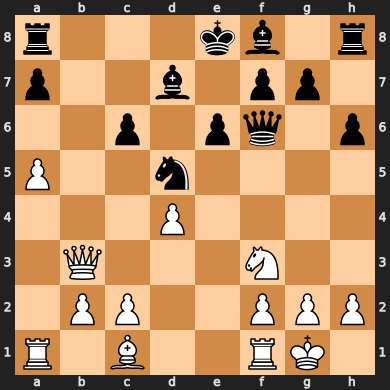

In [21]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [22]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.76      0.64      0.70     85601
           1       0.50      0.57      0.53     85601
           2       0.52      0.57      0.54     85601
           3       0.59      0.50      0.54     85601
           4       0.56      0.55      0.55     85601
           5       0.49      0.59      0.54     85601
           6       0.76      0.64      0.69     85601

    accuracy                           0.58    599207
   macro avg       0.59      0.58      0.58    599207
weighted avg       0.59      0.58      0.58    599207



In [23]:
import json
import time

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = "experiments/logs"):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = "experiments/logs"):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [24]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = "experiments/results"):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [27]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "AdamW",
    "input_shape": 775,
    "output_shape": 7
}

dataset_paths = {
    "train": str(TRAIN_PATH),
    "val":   str(VAL_PATH),
    "test":  str(TEST_PATH)
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/run_2026_01_05_wide_mlp_v1_config.json
[Logs] Saved training history to experiments/logs/run_2026_01_05_wide_mlp_v1_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        57.88%
[Results] Off-by-1 Acc:    86.76%
[Results] MAE:             0.6503
[Results] Latency:         0.0131 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 22353 samples
   - Off by 4: 8405 samples
   - Off by 5: 4112 samples
   - Off by 6: 1455 samples
[Results] Saved all metrics to experiments/results
------------------------------------------------------------


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(experiment_name: str, save_dir: str = "experiments/results"):
    matrix_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    try:
        cm = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Could not find matrix at {matrix_path}")
        return

    class_names = [
        "White Win", "White Decisive", "White Better", "Equal", 
        "Black Better", "Black Decisive", "Black Win"
    ]

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f"Confusion Matrix: {experiment_name}")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.show()

# plot_confusion_matrix(RUN_ID)

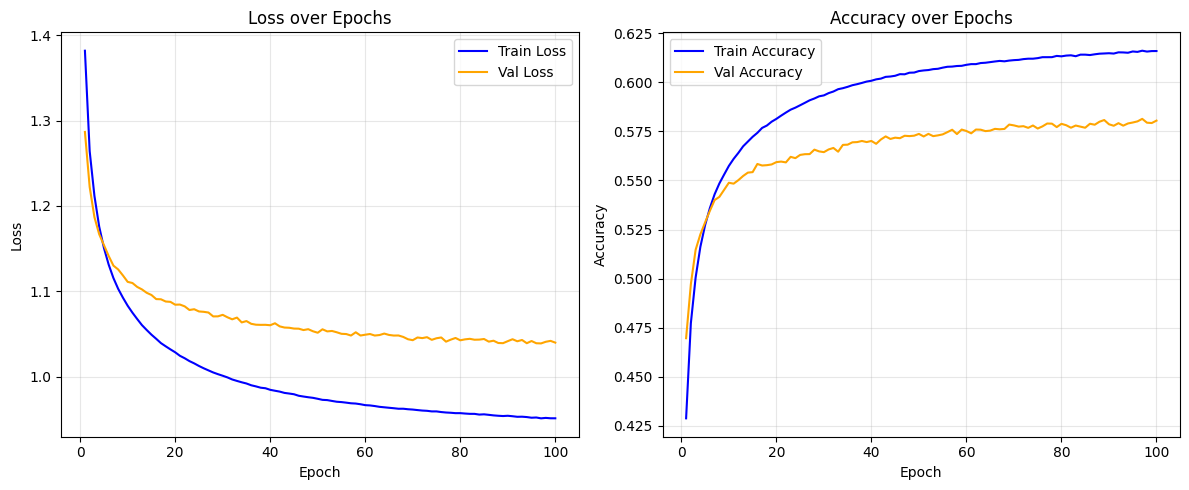

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{model_save_name}/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
def vector_to_fen(vector):
    """
    Reconstructs a FEN string from the 775-dim bitboard vector.
    """

    index_to_piece = {
        0: 'P', 1: 'N', 2: 'B', 3: 'R', 4: 'Q', 5: 'K',
        6: 'p', 7: 'n', 8: 'b', 9: 'r', 10: 'q', 11: 'k'
    }
    
    board = chess.Board(None) 
    
    for piece_idx in range(12):
        for square in range(64):
            idx = piece_idx * 64 + square
            if vector[idx] == 1:
                piece = chess.Piece.from_symbol(index_to_piece[piece_idx])
                board.set_piece_at(square, piece)
                
    board.turn = chess.WHITE if vector[768] == 1 else chess.BLACK

    castling_fen = ""
    if vector[769] == 1: castling_fen += "K"
    if vector[770] == 1: castling_fen += "Q"
    if vector[771] == 1: castling_fen += "k"
    if vector[772] == 1: castling_fen += "q"
    if castling_fen == "": castling_fen = "-"
    
    board.set_castling_fen(castling_fen)
    
    return board.fen()

In [51]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def generate_saliency_map(model, input_tensor, target_class):
    """
    input_tensor: Shape (1, 19, 8, 8) or (1, 775)
    target_class: The class index (0-6) you want to explain (e.g., the WRONG prediction)
    """
    model.eval()
    
    # Enable Gradient Calculation for the Input 
    input_tensor.requires_grad_()
    
    # Forward Pass
    output = model(input_tensor)
    
    # Focus on the specific class score we want to explain
    # (e.g., "Why did you predict Class 0?")
    score = output[0, target_class]
    
    # Backward Pass (Calculate Gradients)
    score.backward()
    
    # Get the Gradients (Sensitivity)
    # Shape matches input. e.g. (1, 19, 8, 8)
    gradients = input_tensor.grad.data.abs()
    
    # Collapse Channels to get a single 8x8 Heatmap
    # For CNN (19, 8, 8) -> Take max across channels -> (8, 8)
    if len(gradients.shape) == 4:
        heatmap, _ = torch.max(gradients[0], dim=0)
    
    # For MLP (1, 775) -> Reshape first 768 bits to (12, 8, 8) then max
    else:
        # Extract just the board bits (0-768), ignore global bits
        board_bits = gradients[0, :768].view(12, 8, 8)
        heatmap, _ = torch.max(board_bits, dim=0)
        
    return heatmap

def plot_chess_heatmap(heatmap, fen_str):
    """Overlay the heatmap on a chess board"""
    heatmap = heatmap.numpy()
    
    plt.figure(figsize=(6, 6))
    
    # 'hot' colormap: White/Yellow = High Attention, Black/Red = Low Attention
    sns.heatmap(heatmap, cmap='hot', annot=False, cbar=True, square=True)
    
    plt.title(f"Model Attention Map\n{fen_str}")
    plt.gca().invert_yaxis() # Match chess board orientation (Rank 1 at bottom)
    plt.show()

Analyzing failure at dataset index: 41594
Reconstructed FEN: 8/8/1p3k2/p1p5/P1P2P1K/8/7n/3q2R1 w - - 0 1
True Class Label: 0
Model Predicted: 6 (Error: 6 bins)


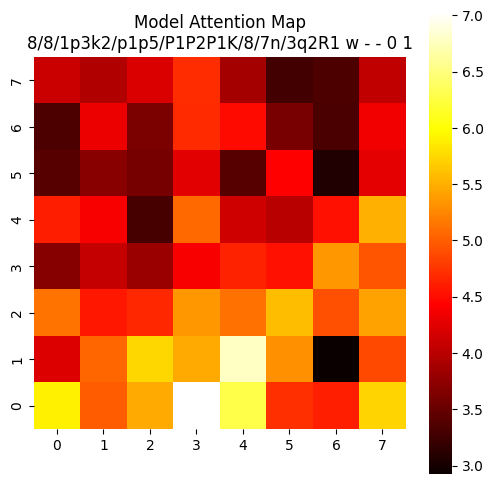

In [52]:
from pathlib import Path
import json
import numpy as np
import chess
import torch
import torch.nn as nn

class WideMLP(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.network(x)

# Load Failure Indices
failure_path = Path(f"./experiments/results/{model_save_name}/{RUN_ID}_failure_indices.json")
with open(failure_path, 'r') as f:
    failures = json.load(f)

# Pick an index from the "3" bin (Errors off by 3 classes)
# --------------------------------------------------------------------------------------------------------------------------------------------------
target_error_bin = "6"
# --------------------------------------------------------------------------------------------------------------------------------------------------
if target_error_bin in failures and failures[target_error_bin]:
    target_idx = failures[target_error_bin][400] # Pick the first failed case
    print(f"Analyzing failure at dataset index: {target_idx}")
else:
    raise ValueError(f"No failures found for bin {target_error_bin}")

# Load the Dataset Row
data_path = TEST_PATH
data = np.load(data_path)

# Extract vector and label
input_vector = data['X'][target_idx] 
true_label = int(data['y'][target_idx])

# Reconstruct FEN
fen_str = vector_to_fen(input_vector)
print(f"Reconstructed FEN: {fen_str}")
print(f"True Class Label: {true_label}")

# Load Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = Path(f"{model_save_name}.pth")

model = WideMLP(input_shape=775, hidden_units=2048, output_shape=7)
# Load weights (assuming state_dict was saved)
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
except:
    # Fallback if full model was saved instead of state_dict
    model = torch.load(model_path, map_location=device)

model.to(device)
model.eval()

# Generate Heatmap
input_tensor = torch.tensor(input_vector, dtype=torch.float32).unsqueeze(0).to(device)

# We usually want to explain the WRONG prediction (why did it pick that?) or the TRUE label (what did it miss?).
with torch.no_grad():
    logits = model(input_tensor)
    predicted_class = torch.argmax(logits, dim=1).item()

print(f"Model Predicted: {predicted_class} (Error: {abs(predicted_class - true_label)} bins)")

# Visualize attention for the PREDICTED (wrong) class
heatmap = generate_saliency_map(model, input_tensor, target_class=predicted_class)
plot_chess_heatmap(heatmap.cpu(), fen_str)

White to move


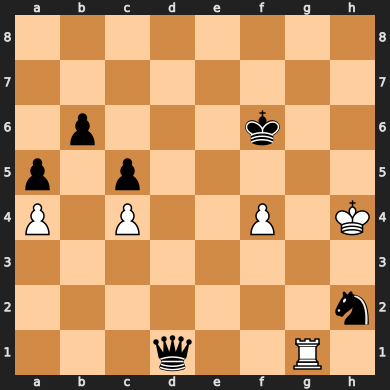

In [48]:
board = chess.Board(fen_str)
if board.turn == chess.WHITE:
    print("White to move")
else:
    print("Black to move")
board

Analyzing performance across Game Phases...


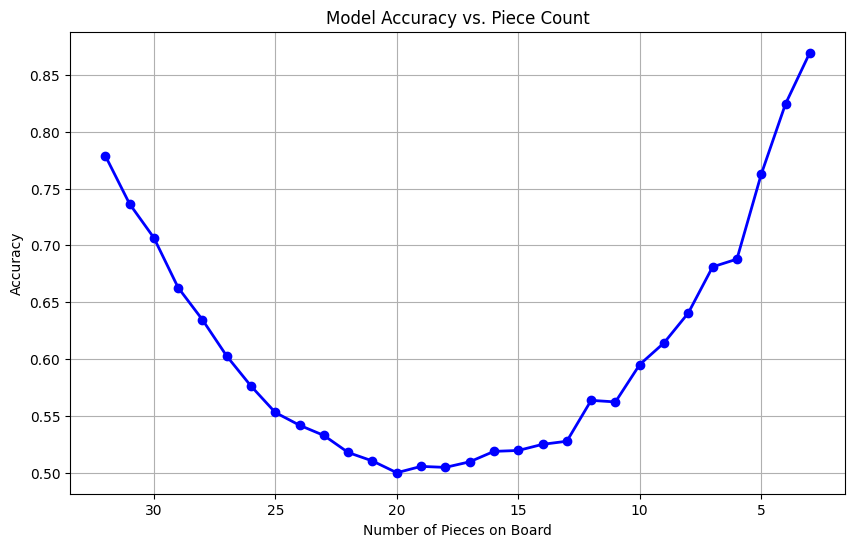

In [57]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_game_phase_performance(model, test_loader, device):
    model.eval()
    
    # Dictionary to store results: { piece_count: [correct_predictions, total_samples] }
    phase_stats = {i: [0, 0] for i in range(33)} # Max 32 pieces on board
    
    print("Analyzing performance across Game Phases...")
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            
            X_cpu = X.cpu().numpy()
            y_cpu = y.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            for i in range(len(y_cpu)):
                # 1. Count Pieces (Sum of first 768 bits)
                # Note: This counts Kings too. 
                piece_count = int(np.sum(X_cpu[i, :768]))
                
                # 2. Record Correctness
                is_correct = 1 if preds_cpu[i] == y_cpu[i] else 0
                
                phase_stats[piece_count][0] += is_correct
                phase_stats[piece_count][1] += 1
                
    # --- PROCESS & PLOT ---
    
    counts = []
    accuracies = []
    
    # We aggregate slightly to avoid noise (e.g., group 3-5 pieces together)
    # But for a raw plot, let's just do Piece Count 3 to 32
    valid_piece_counts = sorted([k for k, v in phase_stats.items() if v[1] > 50]) # Filter rare counts
    
    for pc in valid_piece_counts:
        correct, total = phase_stats[pc]
        acc = correct / total
        counts.append(pc)
        accuracies.append(acc)
        
    # PLOT
    plt.figure(figsize=(10, 6))
    plt.plot(counts, accuracies, marker='o', linewidth=2, color='b')
    plt.title("Model Accuracy vs. Piece Count")
    plt.xlabel("Number of Pieces on Board")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.gca().invert_xaxis() # Standard Chess Style: Endgames (Low numbers) on the Right
    plt.show()
    
    return counts, accuracies

# Run it
counts, accs = analyze_game_phase_performance(model, test_dataloader, device)

Analyzing performance across Game Phases (0-24)...


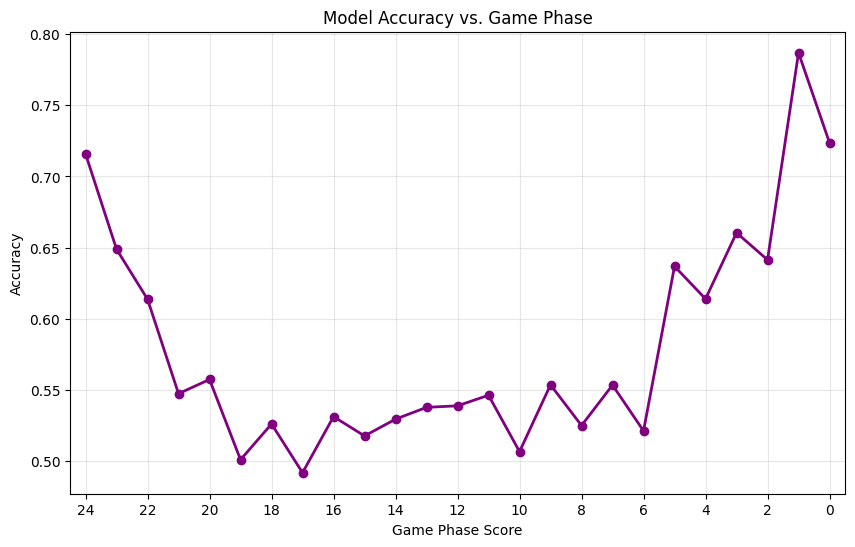

In [56]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def analyze_phase_performance(model, test_loader, device):
    model.eval()
    
    # Dictionary to store results: { phase_score: [correct_predictions, total_samples] }
    # Phase scores range from 0 to 24
    phase_stats = {i: [0, 0] for i in range(25)} 
    
    print("Analyzing performance across Game Phases (0-24)...")
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            
            X_cpu = X.cpu().numpy()
            y_cpu = y.cpu().numpy()
            preds_cpu = preds.cpu().numpy()
            
            # Vectorized Phase Calculation for the whole batch (Faster)
            # 1. Knights (White + Black)
            n_count = np.sum(X_cpu[:, 64:128], axis=1) + np.sum(X_cpu[:, 448:512], axis=1)
            # 2. Bishops
            b_count = np.sum(X_cpu[:, 128:192], axis=1) + np.sum(X_cpu[:, 512:576], axis=1)
            # 3. Rooks
            r_count = np.sum(X_cpu[:, 192:256], axis=1) + np.sum(X_cpu[:, 576:640], axis=1)
            # 4. Queens
            q_count = np.sum(X_cpu[:, 256:320], axis=1) + np.sum(X_cpu[:, 640:704], axis=1)
            
            # Formula: N*1 + B*1 + R*2 + Q*4
            phases = (n_count * 1) + (b_count * 1) + (r_count * 2) + (q_count * 4)
            phases = np.minimum(phases, 24).astype(int)
            
            # Update Stats
            for i, phase in enumerate(phases):
                is_correct = 1 if preds_cpu[i] == y_cpu[i] else 0
                phase_stats[phase][0] += is_correct
                phase_stats[phase][1] += 1
                
    # --- PROCESS & PLOT ---
    counts = []
    accuracies = []
    
    # Filter valid phases (some deep endgames might have 0 samples)
    valid_phases = sorted([k for k, v in phase_stats.items() if v[1] > 20])
    
    for p in valid_phases:
        correct, total = phase_stats[p]
        acc = correct / total
        counts.append(p)
        accuracies.append(acc)
        
    # PLOT
    plt.figure(figsize=(10, 6))
    plt.plot(counts, accuracies, marker='o', linewidth=2, color='purple')
    
    plt.title("Model Accuracy vs. Game Phase")
    plt.xlabel("Game Phase Score")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    
    # Invert X axis: Start (24) -> End (0)
    plt.xlim(24.5, -0.5)
    plt.xticks(range(0, 25, 2))
    
    plt.show()
    
    return counts, accuracies

# Run it
counts, accs = analyze_phase_performance(model, test_dataloader, device)